# Введение в искусственный интеллект на Pytorch

## Обучение с подкреплением

#### Алексей В. Бузмаков

Почта: [abuzmakov@gmail.com](mailto://abuzmakov@gmail.com)

## Скачать https://bit.ly/2022-IT-Univ-Pytorch

## Moodle: https://uchebnik.permkrai.ru/moodle/course/view.php?id=349



## Что же такое "Обучение с подкреплением"?

[Ссылка](https://www.youtube.com/watch?v=Lu56xVlZ40M) на видео от OpenAI.

Агент оперирует в некоторой среде (Environment), получая из неё информацию (Observe state) и предпринимая действие (Take action).

В результате, среда возвращает нагруда за каждое действие.

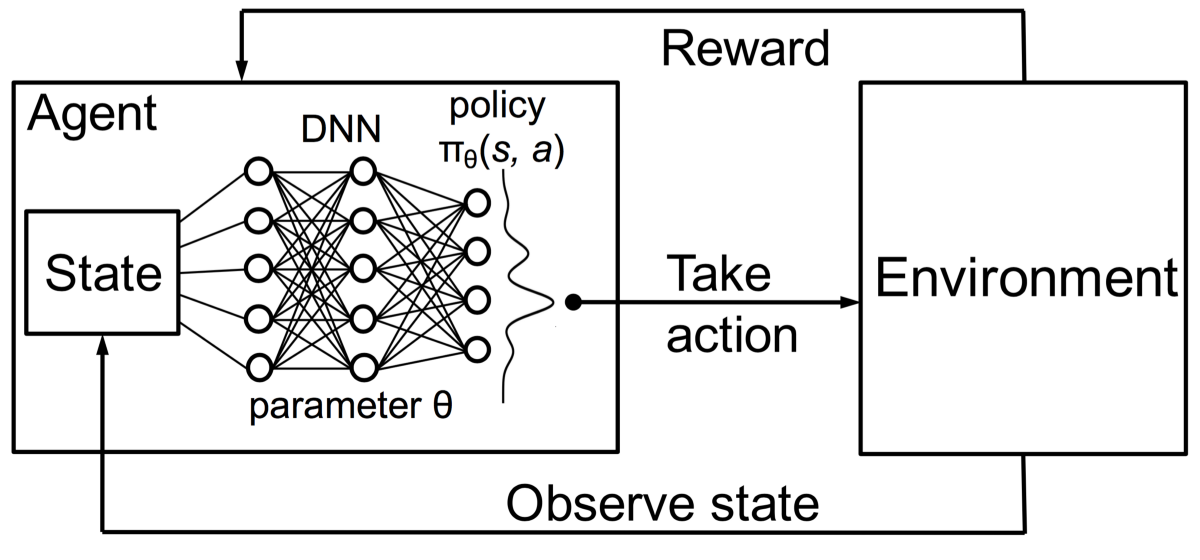

In [ ]:
#@title Примонтирование Google Drive
# МЕНЯ ВСТАВИТЬ В САМОЕ НАЧАЛО, А ПРИ ПОВТОРНОЕ РАБОТЕ ВСЕГДА ЗАПУСКАТЬ!
FOLDER = "2022-IntroPytorch" # Тут имя папки, в которую все сохраняется. Менять это имя можно. 
                        #  На Google Drive должно быть та же папка
                        # Регистр (ЗАГЛАВНЫЕ или строчные буквы) важен! 

PATH = "drive/MyDrive/" + FOLDER  + "/"
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append(PATH)

Mounted at /content/drive


## Подготавливаем среду

In [ ]:
# Установка нужных пакетов
#!pip install box2d-py
#!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1
#!pip install gym-notebook-wrapper
#!pip install pygame
#!pip install gdown

In [ ]:
!pip install pettingzoo
!pip install multi-agent-ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 816 kB 5.0 MB/s 
     |████████████████████████████████| 836 kB 42.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 778 kB 4.8 MB/s 


In [ ]:
!pip install autorom[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441028 sha256=bcfed182234b47b4a08669241211c844a5784e6bc684816fcfcfb633cadcca56
  Stored in directory: /root/.cache/pip/wheels/51/08/c5/28b973078691a3f8baf99fcaec1ed8f0e05ef6e54d2390212c
Successfully built AutoROM.accept-rom-license


In [ ]:
# (!) Нужно будет наyжать "Y"
!AutoROM

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.8/dist-packages/AutoROM/roms
	/usr/local/lib/python3.8/dist-packages/multi_agent_ale_py/roms

Existing ROMs will be overwritten.

I own a license to these Atari 2600 ROMs.
I agree to not distribute these ROMs and wish to proceed: [Y/n]: y
Installed /usr/local/lib/python3.8/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.8/dist-packages/multi_agent_ale_py/roms/adventure.bin
Installed /usr/local/lib/python3.8/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.8/dist-packages/multi_agent_ale_py/roms/air_raid.bin
Installed /usr/local/lib/python3.8/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.8/dist-packages/multi_agent_ale_py/roms/alien.bin
Installed /usr/local/lib/python3.8/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.8/dist-packages/multi_agent_ale_py/roms/amidar.bin
Installed /usr/local/lib/python

In [ ]:
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
import base64
import os
import io

def show_video(image_path):

  if not os.path.exists(f'{image_path}.mp4'):
    os.system(f"ffmpeg -framerate 60 -pattern_type glob -i '{image_path}/*.png' -c:v libx264 -pix_fmt yuv420p {image_path}.mp4")

  video = io.open(f'{image_path}.mp4', 'r+b').read()
  encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
          controls style="height: 400px;">
          <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))


# Мы будем играть в БОКС

Вручную можно поиграть [тут](https://www.free80sarcade.com/atari2600_Boxing.php).

Краткое описание можно найти [тут](https://pettingzoo.farama.org/environments/atari/boxing/).

In [ ]:
from pettingzoo.atari import boxing_v2

In [ ]:
env = boxing_v2.parallel_env()

In [ ]:
# Наблюдение это картинка
env.observation_spaces

/usr/local/lib/python3.8/dist-packages/pettingzoo/utils/conversions.py:91: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(


{'first_0': Box(0, 255, (210, 160, 3), uint8),
 'second_0': Box(0, 255, (210, 160, 3), uint8)}

In [ ]:
# 18 действий
env.action_spaces

/usr/local/lib/python3.8/dist-packages/pettingzoo/utils/conversions.py:105: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


{'first_0': Discrete(18), 'second_0': Discrete(18)}

In [ ]:
import numpy as np

def invert_players(image):
  img = image[25:-25,25:-25,:]
  flags = img.sum(axis=2)
  img[flags == 0] = np.array([214]*3)
  img[flags == 214*3] = np.array([0,0,0])
  image[25:-25,25:-25,:] = img
  return image

def correct_observations(observations):
  observations["second_0"] = invert_players(observations["second_0"].copy())
  return observations


In [ ]:
import torch
from torch.distributions import Categorical
from torchvision.utils import save_image
import os

def play_with_agents(env, agents, max_steps = 200, device = None, render = True):
  if device:
    for name, agent in agents.items():
      agent.to(device)
    
  if render:
    os.system("mkdir -p images")
    os.system("rm -r images/*")
    
  frame = 0

  total_reward = {}
  render_result = {}
  trajectories = {agent_name:{'observations':[], 'actions':[], 'rewards':[]} for agent_name in agents.keys()} # Заполнение этого словаря -- одно из заданий

  observations = correct_observations(env.reset())
 
  while env.agents:
    if render:
      # Сохраняем картинки для всех агентов
      for a in env.agents:
        agent_path = f'images/{a}/'
        if a not in render_result:
          render_result[a] = agent_path
          os.system(f"mkdir -p images/{a}")

        img = torch.tensor(observations[a],dtype=torch.float64)
        img /= 255.0
        img = img.permute(2,0,1)
        save_image(img, f'{agent_path}/frame{frame:05d}.png')

    frame += 1

    actions = {}
    for agent_name in env.agents:
      probs = agents[agent_name](
          torch.FloatTensor(observations[agent_name]).to(device))
      
      dist = Categorical(probs)
      action = dist.sample().item()

      actions[agent_name] = action

      trajectories[agent_name]['observations'].append(observations[agent_name])
      trajectories[agent_name]['actions'].append(action)

    observations, rewards, terminations, truncations, infos = env.step(actions)
    observations = correct_observations(observations)

    for agent_name in agents:
      total_reward[agent_name] = total_reward.get(agent_name, 0) + rewards[agent_name]
      trajectories[agent_name]['rewards'].append(rewards[agent_name])


    if all([f for f in terminations.values()]):
      break
    if frame > max_steps:
      break

  if render:
    #create_video("images/")
    os.system("ffmpeg -framerate 60 -pattern_type glob -i './images/*.png' -c:v libx264 -pix_fmt yuv420p out.mp4")

  return trajectories, total_reward, render_result


In [ ]:
import torch

class StunnedAgent:
  '''
  Агент просто стоит на месте
  '''
  def __init__(self):
    # Это конструктор, тут можно определять переменные
    pass

  def __call__(self, state):

    # Агент должен вернуть вероятности каждого действия, а у нас их 18.
    # Бездействие -- действие номер ноль, туда помещаем 100%
    return torch.tensor([1.] + [0.]*17)

In [ ]:
import torch

class UnpredictableAgent:
  '''
  Агент просто стоит на месте
  '''
  def __init__(self):
    # Это конструктор, тут можно определять переменные
    pass

  def __call__(self, state):

    # Агент должен вернуть вероятности каждого действия, а у нас их 18.
    # Любое действие с равной вероятностью
    return torch.tensor([1./18]*18)

In [ ]:
"""# Играем агентами
with torch.no_grad():
  trajectories, rewards, renders = play_with_agents(env, 
                  {'first_0': StunnedAgent(), 'second_0': UnpredictableAgent()}, 
                  max_steps = 1000, 
                  render = True)
rewards
"""

"# Играем агентами\nwith torch.no_grad():\n  trajectories, rewards, renders = play_with_agents(env, \n                  {'first_0': StunnedAgent(), 'second_0': UnpredictableAgent()}, \n                  max_steps = 1000, \n                  render = True)\nrewards\n"

In [ ]:
#show_video(renders['first_0'])

In [ ]:
#show_video(renders['second_0'])

## Задание 1

По аналогии с агентами выше напишите агента, который случайно бегает, но не бьет.

## Задание 2

По аналогии с агентами выше напишите агента, который подходит к своему врагу. Вам предоставляется кусок кода, который определяет координаты вашего боксера и координаты оппонента

In [ ]:
def get_boxer_coordinate(image, player = "you"):
  if player == "you":
    mean_pos = (image[25:-25,25:-25,:] > 210).nonzero()
    return mean_pos[0].float().mean() + 25, mean_pos[1].float().mean() + 25
  else:
    mean_pos = (image[25:-25,25:-25,:] < 10).nonzero()
    return mean_pos[0].float().mean() + 25, mean_pos[1].float().mean() + 25


In [ ]:
import torch
class MyAgent:
  '''
  Агент просто стоит на месте
  '''
  def __init__(self):
    # Это конструктор, тут можно определять переменные
    pass

  def __call__(self, state):

    # Агент должен вернуть вероятности каждого действия, а у нас их 18.
    # Любое действие с равной вероятностью
    my = get_boxer_coordinate(state,player = "you")
    him = get_boxer_coordinate(state,player="him")
    if (abs(my[0]-him[0])<=7) and (abs(my[1] - him[1]) <= 7):
      return torch.tensor([.1]+[.9]+[0.]*8 + [0.]*8)
    else:
      if (my[1]<him[1]) and (my[0]<him[0]):
        return torch.tensor([0.]+[.1]+[0.]*6+[.9]+[0.]*9)
      elif (my[1]<him[1]) and (my[0]>=him[0]):
        return torch.tensor([0.]+[.1]+[0.]*4+[.9]+[0.]*11)
      elif (my[1]>=him[1]) and (my[0]<him[0]):
        return torch.tensor([0.]+[0.]+[.1]*7+[.9]+[0.]*8)
      elif (my[1]>=him[1]) and (my[0]>=him[0]):
        return torch.tensor([0.]+[.1]+[0.]*5+[.9]+[0.]*10)
      else:
        return torch.tensor([0.]+[1.])

In [ ]:
with torch.no_grad():
  trajectories, rewards, renders = play_with_agents(env, 
                  {'first_0': UnpredictableAgent(), 'second_0': MyAgent()}, 
                  max_steps = 1000, 
                  render = True)
rewards

{'first_0': -4, 'second_0': 4}

In [ ]:
show_video(renders['first_0'])

# Основная идея

Пусть сеть умееет как-то предсказывать действия. 
Тогда она могла бы сыграть следующим образом

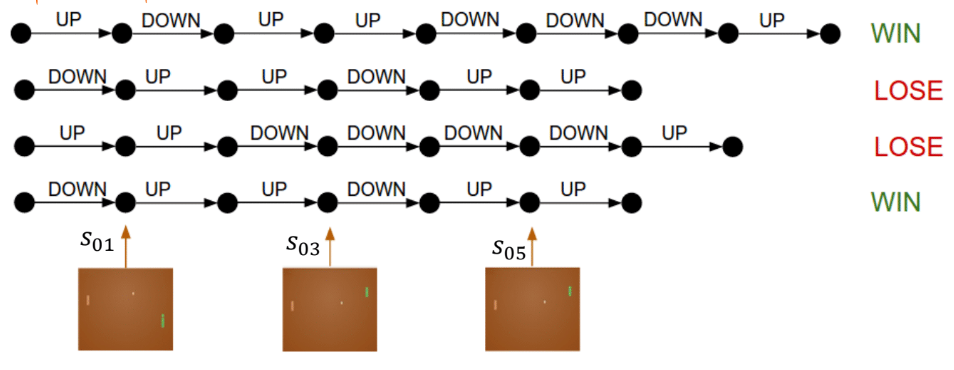

это можно сформировать в следующие данные

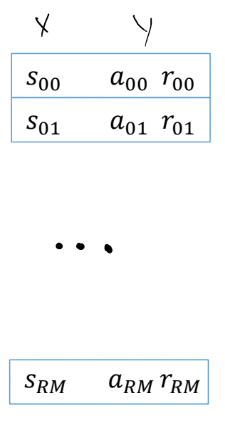

и обучить любую сеть

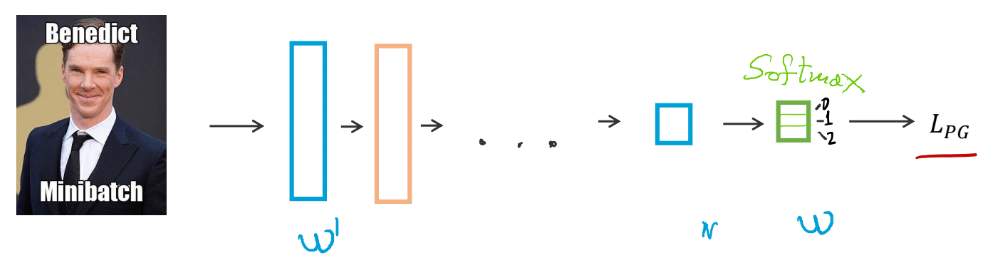

результат игры можем сохранить так

In [ ]:
import torch
import pandas as pd

tmp = pd.DataFrame({'state': [torch.rand((210,160,3))]*3, 'action':[0,17,2], 'reward':[0.,1.,10.]})


# Задание

1) Модифицируйте функцию play_with_agents, которая сохраняет траекторию, сыгранную каждым из агентов (в этой функции уже подготовлен пустой словарик, в который по ключю имени агента, должна возвращаться траектория). Выше показа пример, как сохранять траекторию.

1) Напишите сеть-агента (теперь агент должен наследоваться от nn.Module) для предсказания действия по состоянию:

* nn.Conv2D->nn.Relu->nn.MaxPool2D(10)->nn.Conv2D->nn.Relu->nn.Flatten->nn.Linear->Softmax.

Сколько входов? Сколько выходов?

3) Сохраните одну тракеторию этой модели с помощью написанной выше модели.

# Обучение нейронной сети.

## Награда

Нам нужно в награду учитывать не только текущий результат, но и последствия.

In [ ]:
DISCOUNT = .33
tmp["R"] = tmp.reward
for i in reversed(range(tmp.shape[0]-1)):
  tmp.R[i] += tmp.R[i+1] * DISCOUNT



<ipython-input-23-70851a7512ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.R[i] += tmp.R[i+1] * DISCOUNT


In [ ]:
def compute_total_reward(trajectory, discount = 0.9):
  R = np.array(trajectory["rewards"]).astype(np.float32)
  for i in reversed(range(R.shape[0]-1)):
    R[i] += R[i+1] * discount
  trajectory['R'] = R
  return R


In [ ]:
compute_total_reward(trajectories['second_0'], 0.9)

array([0.00031545, 0.0003505 , 0.00038944, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

# Функция потерь

Мы для каждого состояния (первая колонка в таблице) мы можем расчитать вероятности каждого действия $p_i$ с точки зрения нашей модели, где $i$ -- это номер действия.

Пусть кумулятивная награда была $R$ (последняя колнка в таблице), тогда, если вероятность фактически предпринятого действия была $p_a$, то в функцию потерь для данного наблюдения мы относим: 
$$-R \cdot \log p_a$$

In [ ]:
def compute_trajectory_loss(trajectory, agent):
  loss = 0
  for i in range(len(trajectory['observations'])):
    p = agent(torch.FloatTensor(trajectory['observations'][i]))
    p_a = p[trajectory['actions'][i]]
    loss += -trajectory['R'][i] * torch.log(p_a)
  return loss

In [ ]:
compute_trajectory_loss(trajectories['second_0'], MyAgent())

tensor(16.5998)

# Основной цикл обучения

Сначала определим параметры обучения

In [ ]:
# Основной цикл обучения
NUM_EPISODES = 1 # количество эпизодов, которые будут сыграны для обучения
DISCOUNT = 0.9 # фактор дисконтирования
TRAIN_EVERY = 1 # Сколько нужно накопить траекторий с одной стратегией прежде чем обновлять веса


Теперь, когда мы опредлели вспомогательные функции и метапарметры обучения, нам следует написать основной цикл обучения агента. 

В цикле должно происходить следующее:

1. Играем количество эпизодов, определенное в гиперпараметре NUM_EPISODES.
1. В каждом эпизоде сохраняем информацию о шагах на траектории - состояние, действие и награду.
1. В конце каждого эпизода сохраняем вышеуказанную информацию о траектории.
1. Периодически обучаемся на собранных эпизодах каждые TRAIN_EVERY эпизодов:
  1. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.
  1. Обновляем параметры политики агента по формуле, приведенной на схеме.

**Задание:** Реализовать алгоритм обучения, описанный на схеме и в тексте выше. Шаблон кода алгоритма представлен ниже.


In [ ]:
import torch
import torchvision
model = torchvision.models.shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features,18)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Это просто заглушка, тут должен быть ваш агент
class StuppidAgent(torch.nn.Module):
  def __init__(self):
   super(StuppidAgent, self).__init__()
   self.model = model
   self.device = device
   self.softmax =torch.nn.Softmax()
  
  def __call__(self, state):
    state = state.to(self.device)
    image = state.permute(2,0,1)
    image = image / 255.0
    image = torch.unsqueeze(image[:, 30:-30,30:-30], dim = 0)
    image = self.model(image)
    image = torch.flatten(image)
    

    return self.softmax(image) + 0.2/18


In [ ]:
agent = StuppidAgent()
agent.load_state_dict(torch.load(PATH+'da.pth'))

In [ ]:
from torch.optim import AdamW

agent = StuppidAgent()
agent.train()

optim = AdamW(agent.parameters())

trajectories = []
cur_total_reward = 0

for game in range(NUM_EPISODES):
  # Собираем траекторию
  #  Это должна быть вами написанная функция (точнее поправленная!)
  #  Я предполагаю, что в отличие от моей функция, возвращающей
  #  total_reward, renders
  #  Это функция ещё и возращает словарик с тракеторией для каждого агента, т.е.
  #  trajectories, total_reward, render
  #  При этом каждое значение блока trajectories -- это pd.DataFrame, как выше
  trajs, total_rewards, _ = play_with_agents(
      env, 
      {'first_0': agent, 'second_0': MyAgent()},
       max_steps = 2000, device = None, render = False)
  # Получаем интересующую нас траекторию
  traj = trajs['first_0']
  cur_total_reward += total_rewards['first_0']
  # Расчитываем накопительную награду для этой траектории (колонка R)
  compute_total_reward(trajs['first_0'], discount = 0.95)
  # Сохраняем траекторию
  trajectories.append(traj)

  if (game % TRAIN_EVERY) == 0:
    # Теперь непосредственно обучение.
    loss = 0
    for traj in trajectories:
      # В traj уже есть колонка R, т.е. колонка с накопительной наградой!
      loss += compute_trajectory_loss(traj, agent)
    
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f'Trained GAME {game}. Avg. Total Reward is {cur_total_reward / TRAIN_EVERY}.')
    trajectories = []
    cur_total_reward = 0


<ipython-input-30-eb3e1e6a5428>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(image) + 0.2/18


Trained GAME 0. Avg. Total Reward is 2.0.


In [ ]:
torch.save(agent.state_dict(), PATH+"da1.pth")


In [ ]:
# И играем нашим агентом...
# Играем агентами
with torch.no_grad():
  agent.eval()
  _, rewards, renders = play_with_agents( env, 
                  {'first_0': agent, 'second_0': MyAgent()}, 
                  max_steps = 7200, 
                  render = True)
rewards

<ipython-input-30-eb3e1e6a5428>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(image) + 0.2/18


{'first_0': 0, 'second_0': 0}

In [ ]:
show_video(renders['first_0'])

# Заметки
CoordConv
load в __init__